<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [1]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/semantic-segmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=53de701

In [2]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [4]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [ ]:
%pip install -U gdown

In [ ]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

In [ ]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

## Simple Image Inference

### Load Image

In [ ]:
image_path = './assests/ade/ADE_val_00000049.jpg'
image = io.read_image(image_path)
print(image.shape)
show_image(image)

torch.Size([224, 224, 3])


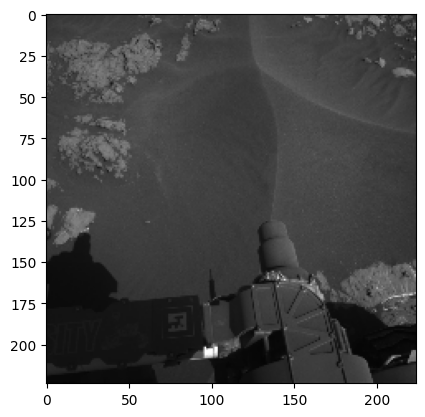

In [9]:
# Load the data loader from the pickle file

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle

class Ai4MarsData(Dataset):
    #X tensor (torch) -> images
    #y tensor (torch) -> labels

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    

with open('/content/drive/MyDrive/Dataset/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


items = data_loader['dataloader'].dataset.__getitem__(1)

print(items[0].shape)

plt.imshow(items[0])
plt.show()

loader = data_loader['dataloader'].dataset



### Preprocess

In [ ]:
image = items[0].permute(2,0,1)
print(image.shape)

# resize
image = T.CenterCrop((224, 224))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

plt.imshow(items[0])
plt.show()

### Model Forward

tensor([[-5.2653, -5.2653, -5.3849,  ..., -2.4197, -2.3618, -2.3618],
        [-5.2653, -5.2653, -5.3849,  ..., -2.4197, -2.3618, -2.3618],
        [-5.2622, -5.2622, -5.3847,  ..., -2.4465, -2.3945, -2.3945],
        ...,
        [-1.4722, -1.4722, -1.5783,  ..., -2.6874, -2.6990, -2.6990],
        [-1.4299, -1.4299, -1.5404,  ..., -2.7014, -2.7127, -2.7127],
        [-1.4299, -1.4299, -1.5404,  ..., -2.7014, -2.7127, -2.7127]])


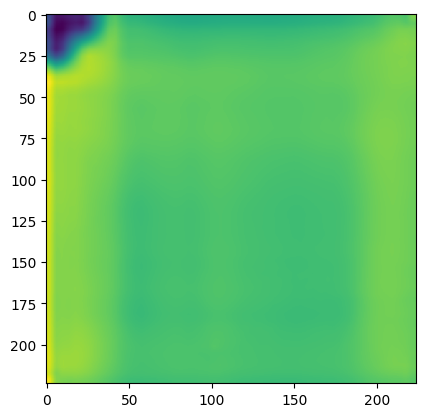

/content/drive/MyDrive/Github/visiope/loss


In [19]:
with torch.inference_mode():
    seg = model(image)

seg.shape
#print(seg)
test_seg_image = seg[0,1,:,:]
print(test_seg_image)


'''
plt.imshow(test_seg_image)
plt.show()

path = "Github/visiope/loss/"
%cd  "/content/drive/MyDrive/""{path}"
torch.save(test_seg_image, './fake_prediction_lable.pt')
'''
test_seg_image.shape

### Postprocess

In [ ]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([ 0,  2, 12])

In [ ]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

In [ ]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)
seg_map.shape

## Show Available Backbones

In [ ]:
from semseg import show_backbones

show_backbones()

## Show Available Heads

In [ ]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [ ]:
from semseg import show_datasets

show_datasets()

## Construct a Custom Model

### Choose a Backbone

In [ ]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [ ]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [ ]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

### Choose a Head

In [ ]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [ ]:
seg = head(features)
seg.shape

In [ ]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.